In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy import stats

# Question 1

## **Part 1.1: Work**



#### Read Data

In [52]:
PATH_TO_Q1_DATA = 'data/HW1_Q1_Data.csv'
df = pd.read_csv(PATH_TO_Q1_DATA) 

In [53]:
df.head()

,S IgG1,RBD IgG1,N IgG1,S IgG2,RBD IgG2,N IgG2,S IgG3,RBD IgG3,N IgG3,S IgG4,...,NT50,Sex,Race,Age,Remdesivir,Antibiotics,Chloroquines,Tocilizumab,Ards,Outcome
0,15518.25,11686.50,17408.00,2595.00,2977.5,4418.75,7988.75,10112.75,13740.75,2890.50,...,264.0,Male,Black,60-69,No,Yes,Yes,No,Yes,Died
1,2226.50,2343.25,3379.75,2444.75,3850.5,4687.00,2404.00,3399.00,4383.00,2214.75,...,126.0,Male,White,60-69,No,Yes,Yes,No,Yes,Died
2,2279.75,2450.00,3741.00,2117.00,2321.0,3298.50,2110.75,2256.25,3009.75,2256.75,...,16.0,Female,Asian,80 and older,Yes,No,No,No,No,Died
3,115548.25,93832.00,94973.50,2938.75,2725.0,4380.25,17165.50,14912.00,33445.50,2512.25,...,53.0,Male,Asian,50-59,Yes,Yes,No,No,Yes,Lived
4,2645.00,2479.00,4630.00,2256.75,2408.5,3449.50,2086.00,2452.50,3574.75,2127.00,...,151.0,Female,White,80 and older,Yes,No,No,No,No,Lived


#### Standardize Data in Columns 1-52

In [54]:
'''
 TODO: Standardize columns 1-52 by subtracting off mean of each column and scaling to unit variance
'''
cols = df.iloc[:,:52].columns # get list of columns names for columns 1-52

for col in cols:
    if '_zscore' not in col:
        col_zscore = col + '_zscore' # add column for zscore
    df[col_zscore] = (df[col] - df[col].mean())/ df[col].std() # z =(x-μ)/σ  #??std(ddof=??) degrees of freedom

In [55]:
df.head(1)

,S IgG1,RBD IgG1,N IgG1,S IgG2,RBD IgG2,N IgG2,S IgG3,RBD IgG3,N IgG3,S IgG4,...,S ADCD_zscore,RBD ADCD_zscore,N ADCD_zscore,S NKD-CD107a_zscore,RBD NKD-CD107a_zscore,N NKD-CD107a_zscore,S NKD-MIP1b_zscore,RBD NKD-MIP1b_zscore,N NKD-MIP1b_zscore,NT50_zscore
0,15518.25,11686.5,17408.0,2595.0,2977.5,4418.75,7988.75,10112.75,13740.75,2890.5,...,-0.675782,-0.411877,0.450513,-0.02381,-0.180116,-0.576487,-0.586417,-1.100901,-0.542606,1.019302


In [56]:
# get numeric columns
df_zscore_only = df.iloc[:,61:] # get standardized columns only
df_zscore_only.head()

,S IgG1_zscore,RBD IgG1_zscore,N IgG1_zscore,S IgG2_zscore,RBD IgG2_zscore,N IgG2_zscore,S IgG3_zscore,RBD IgG3_zscore,N IgG3_zscore,S IgG4_zscore,...,S ADCD_zscore,RBD ADCD_zscore,N ADCD_zscore,S NKD-CD107a_zscore,RBD NKD-CD107a_zscore,N NKD-CD107a_zscore,S NKD-MIP1b_zscore,RBD NKD-MIP1b_zscore,N NKD-MIP1b_zscore,NT50_zscore
0,-0.327784,-0.327417,-0.390835,-0.430222,-0.410582,-0.423640,-0.069492,-0.205854,-0.276218,-0.418283,...,-0.675782,-0.411877,0.450513,-0.023810,-0.180116,-0.576487,-0.586417,-1.100901,-0.542606,1.019302
1,-0.388406,-0.383136,-0.448371,-0.445330,-0.359239,-0.409801,-0.628774,-0.437607,-0.343531,-0.607598,...,-0.902038,-0.965508,-0.831518,-0.775527,-0.799010,-0.764606,-1.617719,-1.100901,-1.061439,-0.272266
2,-0.388163,-0.382500,-0.446890,-0.478285,-0.449192,-0.481434,-0.658142,-0.477053,-0.353409,-0.595831,...,-1.280099,-1.033968,-0.560026,0.142907,1.699490,-0.285057,0.513107,0.713034,-0.099106,-1.301777
3,0.128434,0.162469,-0.072702,-0.395658,-0.425432,-0.425626,0.849509,-0.040188,-0.134474,-0.524252,...,0.104725,-0.648830,-2.040266,-0.363199,-0.771504,-0.323606,-0.667148,-0.352029,0.036981,-0.955487
4,-0.386497,-0.382327,-0.443244,-0.464233,-0.444046,-0.473643,-0.660620,-0.470279,-0.349345,-0.632182,...,-0.370782,-1.398593,-2.056404,-0.867817,-0.565206,-0.781568,-1.120830,0.061931,-1.061439,-0.038286


#### Cluster Standardized Data in Columns 1-52

In [117]:
# how to choose distance measure?? 
# how to use other quality metrics if we don't know what true labels are??
kmeans_possible_cluster_nums = [2,3,4,5,6,7,8,9,10] # 1 < k < 11

cluster_quality_scores = []
for k in kmeans_possible_cluster_nums:
    '''
    TODO: 1. Fit data to k clusters using imported clustering algorithm
          2. Compute quality of results for k clusters using imported
             cluster quality metric and store in a list
    '''
    kmeans = KMeans(n_clusters=k).fit(df_zscore_only)
    labels = kmeans.labels_
    score = metrics.silhouette_score(df_zscore_only, labels) # quality
    cluster_quality_scores.append(score)
    
#     print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#     print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#     print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#     print("Adjusted Rand Index: %0.3f"
#           % metrics.adjusted_rand_score(labels_true, labels))
#     print("Adjusted Mutual Information: %0.3f"
#           % metrics.adjusted_mutual_info_score(labels_true, labels))
#     print("Silhouette Coefficient: %0.3f"
#           % metrics.silhouette_score(df_zscore, labels))

cluster_quality_scores

[0.596020600071851,
 0.2896940008974808,
 0.2947191887383796,
 0.28896913761522225,
 0.29556141162317157,
 0.3227814990823057,
 0.27075888390322883,
 0.2598120051119882,
 0.24868132851100483]

In [58]:
# dimensionality reduction and visualization
## how to connect true labels to this??

pca = PCA(n_components=2).fit_transform(df_zscore_only)
df_pca_plot = pd.DataFrame(pca, columns=['pca1','pca2'])
df_pca_plot.head()

,pca1,pca2
0,-2.928040,3.900730
1,-5.351742,4.966922
2,-4.941026,2.733098
3,-2.863161,5.833311
4,-5.368426,3.700281


<AxesSubplot:xlabel='pca1', ylabel='pca2'>

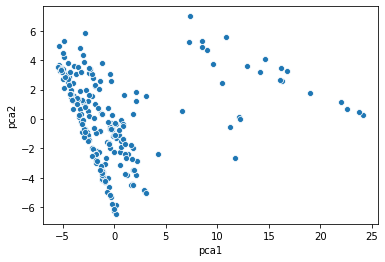

In [59]:
sns.scatterplot(x='pca1', y='pca2', data=df_pca_plot, legend='full')

#### Visualize Cluster Quality Metrics

In [118]:
# Creates line chart to visualize values of cluster quality metric for each possible number of clusters
def plotMetricByK(metric_name, metric_results, possible_clusters, PATH_TO_SAVE=None):
  '''
  metric_name: Name of cluster quality metric for title and axis label
  metric_results: List containing value of metric, in order, for each
                  possible number of clusters
  PATH_TO_SAVE: Path of file to save plot. If path is not provided, image is not saved
  '''

  plt.clf()

  plt.title(f'{metric_name} by Number of Clusters')
  plt.xlabel('Number of Clusters')
  plt.ylabel(metric_name)
  plt.plot(possible_clusters, metric_results)
  
  if PATH_TO_SAVE:
    plt.savefig(PATH_TO_SAVE)

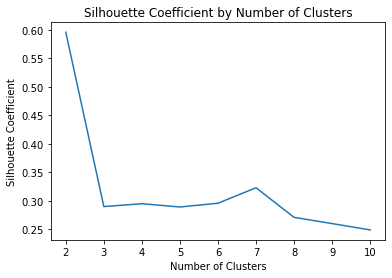

In [119]:
'''
 TODO: Plot your choice of cluster quality metric by cluster number to help determine k.

 TIP: If using the above function, place each function call in a separate 
      cell to visualize multiple cluster quality metrics
'''
plotMetricByK("Silhouette Coefficient", cluster_quality_scores, kmeans_possible_cluster_nums)

## **Part 1.1: Answer**

How many clusters are there in the data? **There appear to be two clusters.**

Explanation: **Good clustering is indicated when the Silhouette Coefficient is close to 1. The Silhouette Coefficient is closest to 1 for two clusters and is much lower for other clustering sizes.**

## **Part 1.2: Work**

#### Cluster Data

In [62]:
'''
  TODO: Cluster data with the number of clusters you determined in part 1.1 and store resulting labels
'''
kmeans = KMeans(n_clusters=2).fit(df_zscore_only)
labels = kmeans.labels_
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [63]:
# add labels as column in data??
df = pd.DataFrame(df)
df['cluster']=labels
df.head()

,S IgG1,RBD IgG1,N IgG1,S IgG2,RBD IgG2,N IgG2,S IgG3,RBD IgG3,N IgG3,S IgG4,...,RBD ADCD_zscore,N ADCD_zscore,S NKD-CD107a_zscore,RBD NKD-CD107a_zscore,N NKD-CD107a_zscore,S NKD-MIP1b_zscore,RBD NKD-MIP1b_zscore,N NKD-MIP1b_zscore,NT50_zscore,cluster
0,15518.25,11686.50,17408.00,2595.00,2977.5,4418.75,7988.75,10112.75,13740.75,2890.50,...,-0.411877,0.450513,-0.023810,-0.180116,-0.576487,-0.586417,-1.100901,-0.542606,1.019302,0
1,2226.50,2343.25,3379.75,2444.75,3850.5,4687.00,2404.00,3399.00,4383.00,2214.75,...,-0.965508,-0.831518,-0.775527,-0.799010,-0.764606,-1.617719,-1.100901,-1.061439,-0.272266,0
2,2279.75,2450.00,3741.00,2117.00,2321.0,3298.50,2110.75,2256.25,3009.75,2256.75,...,-1.033968,-0.560026,0.142907,1.699490,-0.285057,0.513107,0.713034,-0.099106,-1.301777,0
3,115548.25,93832.00,94973.50,2938.75,2725.0,4380.25,17165.50,14912.00,33445.50,2512.25,...,-0.648830,-2.040266,-0.363199,-0.771504,-0.323606,-0.667148,-0.352029,0.036981,-0.955487,0
4,2645.00,2479.00,4630.00,2256.75,2408.5,3449.50,2086.00,2452.50,3574.75,2127.00,...,-1.398593,-2.056404,-0.867817,-0.565206,-0.781568,-1.120830,0.061931,-1.061439,-0.038286,0


#### Univariate Analysis

In [64]:
'''
  TODO: Find 4 variables that have statistically significant differences between values in the clusters (i.e p < 0.05 using pairwise t-tests)
'''

# shapiro ??
stats.shapiro(df['S IgG1'])  # (W test value, p-value)

ShapiroResult(statistic=0.4250958561897278, pvalue=1.2075103120681761e-26)

In [65]:
# do I need to split the data into separate dataframes per cluster to do t-test??
df_cluster0=df[df['cluster']==0]
print(df_cluster0.shape)


df_cluster1=df[df['cluster']==1]
print(df_cluster1.shape)

(207, 114)
(25, 114)


In [66]:
# Welch's t-test
# p-value
# degrees of freedom??
# what to do with this data??
# all my columns have low p-values??
# look at original data or standardized data??
# true or false for equal variance??
# need the same size number in each cluster??
cols = df_cluster0.iloc[:,0:52].columns  # get names of columns
cols
pvalues=[]
for col in cols:
    (stat, pvalue) = stats.ttest_ind(df_cluster0[col], df_cluster1[col], equal_var=False)
    pvalues.append(pvalue)
    print('column: %-21s pvalue: %.10f' % (col,pvalue))

column: S IgG1                pvalue: 0.0000000002
column: RBD IgG1              pvalue: 0.0000000009
column: N IgG1                pvalue: 0.0000000000
column: S IgG2                pvalue: 0.0000000000
column: RBD IgG2              pvalue: 0.0000000000
column: N IgG2                pvalue: 0.0000000000
column: S IgG3                pvalue: 0.0000000000
column: RBD IgG3              pvalue: 0.0000000023
column: N IgG3                pvalue: 0.0000006285
column: S IgG4                pvalue: 0.0000000077
column: RBD IgG4              pvalue: 0.0000002160
column: N IgG4                pvalue: 0.0000004009
column: S IgA1                pvalue: 0.0000000000
column: RBD IgA1              pvalue: 0.0000000000
column: N IgA1                pvalue: 0.0000000103
column: S IgA2                pvalue: 0.0000000003
column: RBD IgA2              pvalue: 0.0000000000
column: N IgA2                pvalue: 0.0000000000
column: S IgM                 pvalue: 0.0000000000
column: RBD IgM               p

In [67]:
np.sort(pvalues)

array([1.65034514e-25, 2.25892527e-15, 4.53873510e-15, 5.94927821e-15,
       1.79577610e-14, 2.19844774e-14, 3.49072496e-14, 4.00278991e-14,
       4.80850844e-14, 2.14180639e-13, 3.63486498e-13, 7.50385130e-13,
       1.25776799e-12, 1.38844425e-12, 1.84662097e-12, 2.62438263e-12,
       5.42320117e-12, 1.13718082e-11, 1.17722311e-11, 3.36182261e-11,
       1.20728715e-10, 1.27347205e-10, 1.64751498e-10, 2.14904198e-10,
       3.13942962e-10, 4.89048061e-10, 8.68893261e-10, 9.63360206e-10,
       2.10790992e-09, 2.26505113e-09, 5.17759478e-09, 7.11267508e-09,
       7.67571310e-09, 1.03229430e-08, 2.29219008e-08, 3.27898210e-08,
       4.29230933e-08, 2.16015766e-07, 4.00867128e-07, 6.28498483e-07,
       2.03872899e-06, 4.69475066e-06, 1.59840175e-05, 4.45293606e-05,
       2.10940070e-03, 3.94577594e-02, 1.45329920e-01, 3.08958741e-01,
       5.28391317e-01, 5.76958110e-01, 7.77626496e-01, 9.57972881e-01])

**Part 1.2: Answer**

VARIABLE 1, VARIABLE 2, VARIABLE 3, VARIABLE 4
S IgG1_zscore, RBD IgG1_zscore, N IgG1_zscore, S IgG2_zscore //dummy values for now

**Replace the above line with 4 variables that you found from the univariate analysis and output the corresponding box plots in the cells below or as images in this cell**

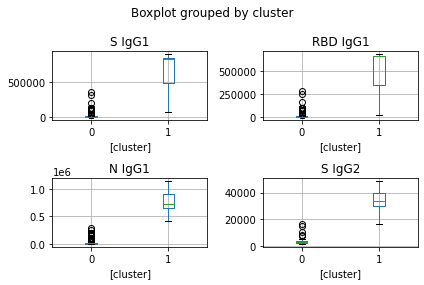

In [69]:
'''
  TODO: Create and display boxplots for each of the 4 variables like those in Fig 1. from the paper by Wu et al

  TIP: 1. If you add the cluster labels as an additional column to the dataframe, then you can follow the example at https://www.pythonprogramming.in/boxplot-group-by-column-data.html
       2. If you want to use subplots to put all 4 boxplots in the same figure, you can plot the dataframes on a specific subplot using the ax keyword. For example,
          
          fig, axs = plt.subplots(2, 2)

          df.boxplot(column=['Variable'], by=['Cluster'], ax=axs[0,0])
          df.boxplot(column=['Variable'], by=['Cluster'], ax=axs[0,1])
''' 

# how to fix labels?
# is this how it should look??
# use standardized data??
fig, axs = plt.subplots(2,2)

df.boxplot(column=['S IgG1'], by=['cluster'], ax=axs[0,0])
df.boxplot(column=['RBD IgG1'], by=['cluster'], ax=axs[0,1])
df.boxplot(column=['N IgG1'], by=['cluster'], ax=axs[1,0])
df.boxplot(column=['S IgG2'], by=['cluster'], ax=axs[1,1])


plt.tight_layout()

## **Part 1.3: Work**


In [70]:
# Formats Pandas series to string of form 'index_1: value_1, ..., index_n:, value_n' w/ indexes alphabetically sorted
def formatValueCounts(value_counts):
  '''
    value_counts: Pandas series
  '''
  count_string = value_counts.to_string()
  formatted_counts = [': '.join(count.split()) for count in count_string.split('\n')]
  formatted_counts.sort()
  return ', '.join(formatted_counts)

# Creates table summarizing data by cluster and categorical feature
def plotSummaryTable(cellText, PATH_TO_SAVE=None):
  '''
  cellText: num_clusters x 9 2D List where cellText[i][j] contains a string summarizing
            the statistics for cluster i and column (53 + j) in the data
  PATH_TO_SAVE: Path of file to save plot. If path is not provided, image is not saved
  '''

  k = len(cellText)
  colLabels = [f'Cluster {i + 1}' for i in range(k)]

  rowLabels = list(df.columns)[52:61]

  cellText = np.array(cellText).T

  plt.figure(figsize=(10,10))
  table = plt.table(cellText, 
              colLabels=colLabels,
              colColours=['#D3D3D3'] * len(colLabels),
              rowLabels=rowLabels,
              rowColours=['#D3D3D3'] * len(rowLabels),
              cellLoc='center',
              loc='upper center')
  table.scale(2,5)
  table.auto_set_font_size(False)
  table.set_fontsize(12)

  plt.axis('off')
  plt.grid(False)

  if PATH_TO_SAVE:
    plt.savefig(PATH_TO_SAVE)

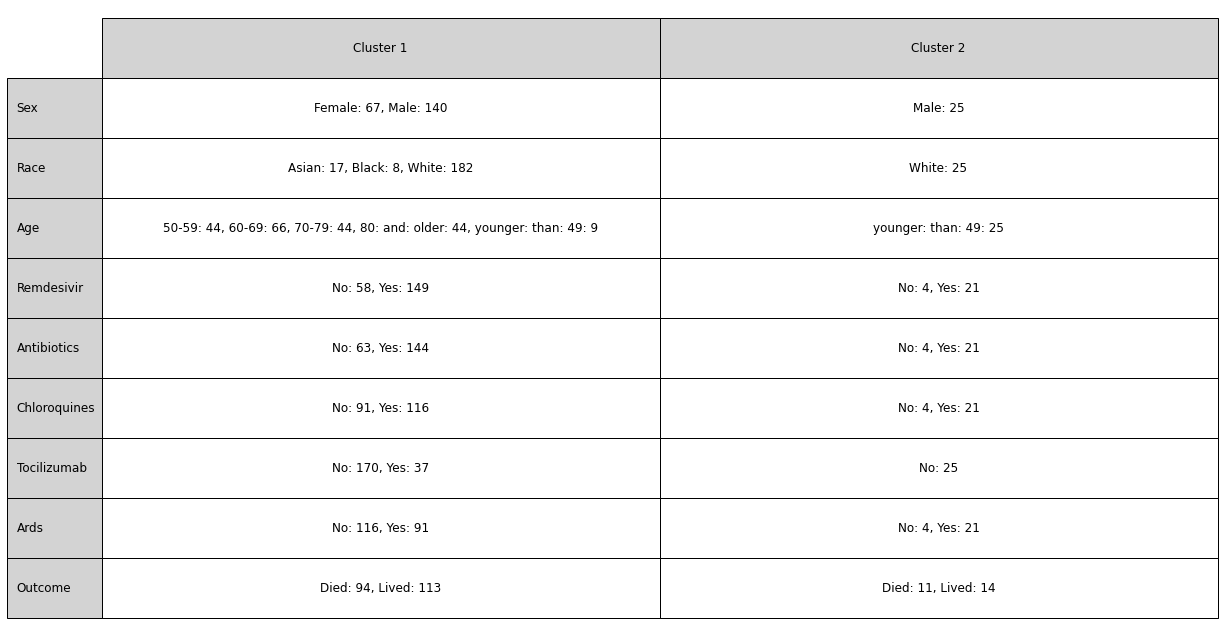

In [71]:
'''
  TODO: Create a table where the rows correspond to the variables in columns 53-61, and the columns correspond to the k clusters you identified.
        For each cell in the table, put summary statistics for that (variable, cluster) pair

  TIP: 1. If you create a 2D list, cellText, where cellText[i][j] contains a string summarizing the statistics for cluster i and column (53 + j) in
          the data, you can pass this into plotSummaryTable (provided above) to automatically create the table with matplotlib
       2. If you use value_counts() from Pandas, you can pass the resulting series to formatValueCounts (provided above) to convert it to a formatted string
'''
#'Sex','Race', 'Age', 'Remdesivir', 'Antibiotics', 'Chloroquines','Tocilizumab', 'Ards', 'Outcome'

# create cellText
rows=2 # 2 clusters
columns=9 # 9 categorical columns
cellText=[[''] * columns for i in range(rows)]


# get summary stats for each categorical column
categorical_cols = df.iloc[:,52:61].columns # subtract 1 because column index starts at 0

for i, col in enumerate(categorical_cols):
    col_num=i
    for cluster in range(0,2):
        df_one_cluster = df[df['cluster']==cluster] # select data for only that cluster
        counts = df_one_cluster[col].value_counts()
        formatted = formatValueCounts(counts)
        cellText[cluster][col_num]=formatted

output_table = plotSummaryTable(cellText)
output_table

## **Part 1.3: Answer**

**Plot the table in one of the above cells or include it as an image in this cell**

Are any of the clusters significantly enriched for some particular value? **Yes. Cluster 2 consists only of white males younger than 49. Cluster 1 is largely white individuals older than 49.**

*what about whether the enrichment is statistically significant??*

## **Part 1.4: Work**

## Clustering

In [120]:
'''
TODO: Cluster the numeric variables (Columns 1-52)
'''
# distance measure: euclidean
# quality: silhouette
hier_possible_cluster_nums = list(range(1,32))

# hierarchical clustering for different distance thresholds
h_quality_scores = []
for d in hier_possible_cluster_nums:
    hier = AgglomerativeClustering(n_clusters=None, distance_threshold=d).fit(df_zscore_only) #?? distance threshold
    h_labels = hier.labels_
    h_labels
    score = metrics.silhouette_score(df_zscore_only, h_labels)
    h_quality_scores.append(score)
    
h_quality_scores

[0.45072814177070614,
 0.5327099279099622,
 0.5111090192176239,
 0.4947049968189609,
 0.47330791944537903,
 0.4533232114948322,
 0.4250845373653124,
 0.39779024413569763,
 0.37827909448988667,
 0.3687390169850836,
 0.34290729649270807,
 0.3113452727876744,
 0.2876730487895541,
 0.2769312205098682,
 0.2769312205098682,
 0.2559774584789223,
 0.24623832525335687,
 0.23283393192881596,
 0.22983274539050572,
 0.22983274539050572,
 0.24625560340627867,
 0.2836800468172528,
 0.2836800468172528,
 0.2836800468172528,
 0.2836800468172528,
 0.2811186940261362,
 0.24835432754259992,
 0.24835432754259992,
 0.24835432754259992,
 0.24835432754259992,
 0.24835432754259992]

## Visualization 1

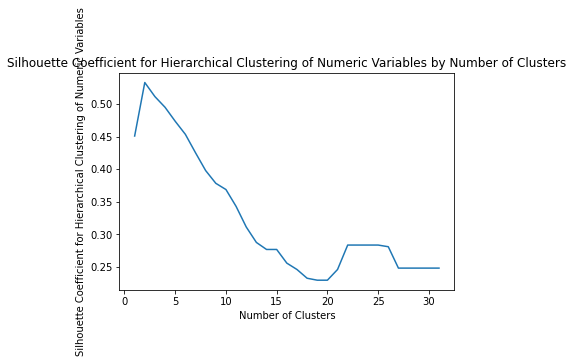

In [121]:
plotMetricByK("Silhouette Coefficient for Hierarchical Clustering of Numeric Variables", h_quality_scores, hier_possible_cluster_nums)

## Visualization 2

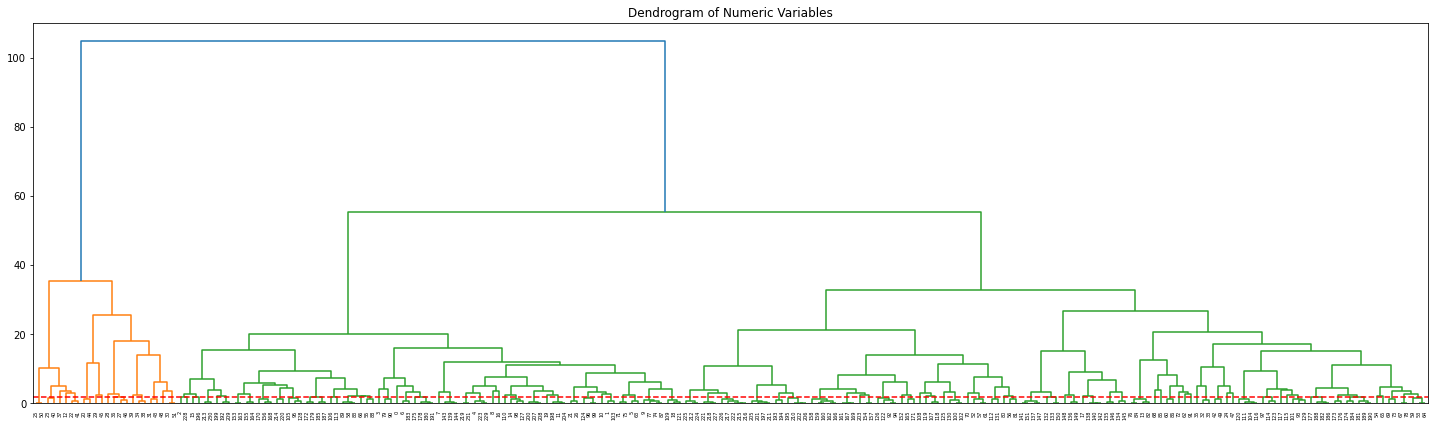

In [125]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(25,7))
plt.title("Dendrogram of Numeric Variables")
dend = shc.dendrogram(shc.linkage(df_zscore_only, method='ward')) # ward??
plt.axhline(y=2, color='r', linestyle='--')
plt.show()

## **Part 1.4: Answer**

How many clusters are there in the numeric variables? **There appear to be 26 clusters of variables.** 

Explanation: **When hierarchical clustering is performed, the quality measure (silhouette coefficient) is highest when the distance measure is 2.**

## **Part 1.5: Work**

In [141]:
#?? how to translate distance into which variables are selected? perform another hierarchical clustering?

hier = AgglomerativeClustering(n_clusters=None, distance_threshold=2).fit(df_zscore_only) #?? distance threshold
h_labels = hier.labels_
h_labels

array([101,  24,  10,  62,  49,  71,  37,  77,  68,  59,  92,  57,  82,
        18,  32,   4,  60, 106,  31, 100,  41,  54,  25,  12,  80,  53,
        54,   0,  91,  93,  51,  20,  33,  33,  55,  97,   0,  67,  55,
        98,  12,  25,  11,  20,  41, 105,   0,  70,  69,  11,  53,  51,
        21,  16, 104,  87,  43,  21,  52,  16,  22,  21,  88,  71,  16,
        73, 109,  90,  63,  35,  86,  95,  76,  35,  59,  95,  18,  59,
        90,  38, 107,  43,  18,  52,  18,  58,  22,  59,  87,  52,  38,
        94,   9,  15,   9,  30,  17,   6,  32,  17,  39,  15,  39,  24,
        13,  30,  14,  96,  81,  31,  99,  13,  26,  14,   6,  48,  13,
        66,  96, 103,  13,  31,   9,   6,  17,  72,   9,  32,  30,  15,
        39,  26,   5,   5,  27,  36,  75,  78,  56,  47,  56,  78,  56,
        47,  47,  27,  36,  78, 102,  75,   5,  78,  46,  89,  74,  40,
        45,  74,  29,  29,  29,  85,  29,  89,  40,  19,  29,  85,  45,
        85,  45,  19,   3,  23,   7,   1,  23,   2,   1,   3,   

In [143]:
'''
TODO: 1. Choose a representative variable from each cluster you determined in Part 1.4
         and create a low-dimensional version of the data using those variables
      2. Re-cluster the data using the reduced representation using the same 
         choices you made for part 1.1.
'''
#? just keep only the variables I care about?

df_reduced_variables = df.filter(items=['S IgG1_zscore','RBD IgG1_zscore','N IgG1_zscore','S IgG2_zscore','RBD IgG2_zscore','N IgG2_zscore'])
df_reduced_variables.head()


kmeans_possible_cluster_nums = [2,3,4,5,6,7,8,9,10] # 1 < k < 11

cluster_quality_scores = []
for k in kmeans_possible_cluster_nums:
    kmeans = KMeans(n_clusters=k).fit(df_reduced_variables)
    labels = kmeans.labels_
    score = metrics.silhouette_score(df_reduced_variables, labels) # quality
    cluster_quality_scores.append(score)

cluster_quality_scores

[0.8904700056978289,
 0.8725932147244077,
 0.8808958161851708,
 0.6950972128545911,
 0.703440289778991,
 0.711322144847075,
 0.7180932309963591,
 0.7516483715576057,
 0.7535936206274931]

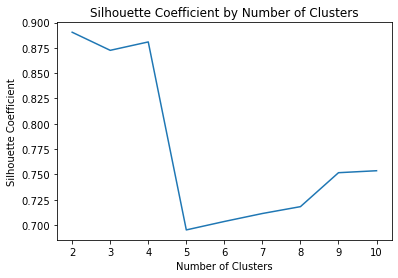

In [144]:
# visualize
plotMetricByK("Silhouette Coefficient", cluster_quality_scores, kmeans_possible_cluster_nums)

In [146]:
# choose cluster k=4
kmeans = KMeans(n_clusters=4).fit(df_reduced_variables)
labels = kmeans.labels_
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       3, 3, 0, 3, 0, 1, 1, 2, 1, 2, 0, 0, 1, 3, 1, 3, 1, 1, 3, 3, 0, 2,
       2, 2, 1, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

## **Part 1.5: Answer**

Representative Variables: **Replace this with the representative variables you chose using your work from Part 1.4** 

How many clusters are there in the numeric variables? **YOUR ANSWER HERE** 

Explanation: **Please make sure any relevant plots are either included in the above cells or linked in this cell and replace this line with a brief explanation of how they justify your choice**

## **Part 1.6: Work**

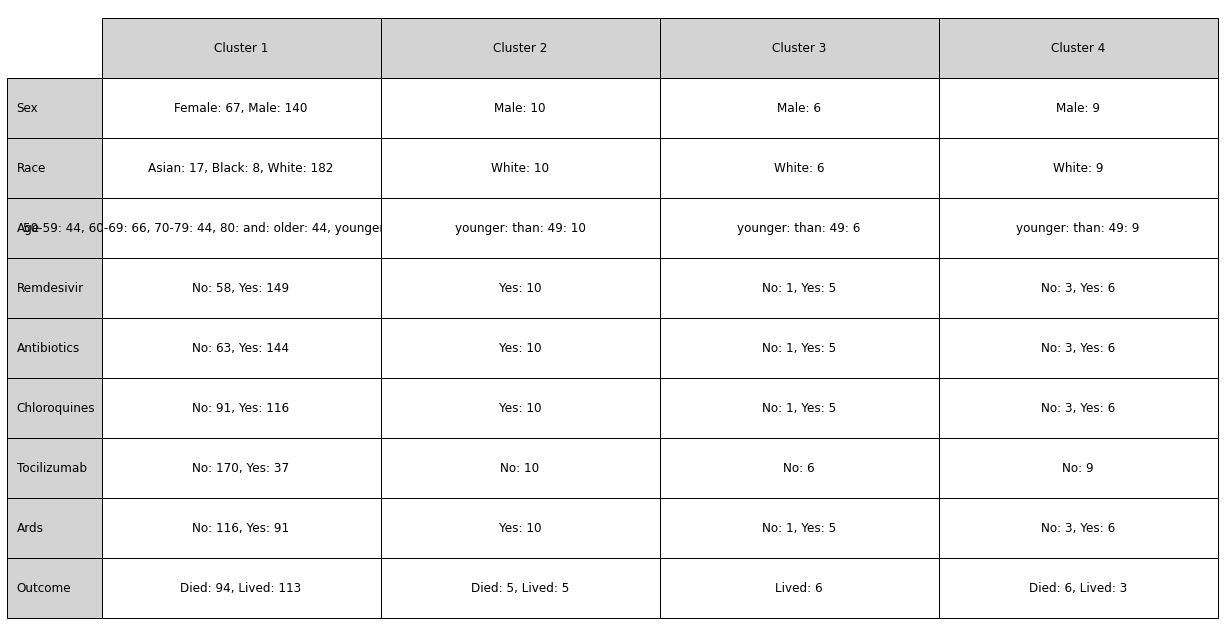

In [157]:
'''
  TODO: Create a table where the rows correspond to the variables in columns 53-61, and the columns correspond to the k clusters you identified.
        in part 1.5. For each cell in the table, put summary statistics for that (variable, cluster) pair
'''
df['low dimension cluster']=labels  # add low dimension clusters
df.head()


# create cellText
rows=4 # 2 clusters
columns=9 # 9 categorical columns
cellText=[[''] * columns for i in range(rows)]


# get summary stats for each categorical column
categorical_cols = df.iloc[:,52:61].columns # subtract 1 because column index starts at 0

for i, col in enumerate(categorical_cols):
    col_num=i
    for cluster in range(0,4):
        df_one_cluster = df[df['low dimension cluster']==cluster] # select data for only that cluster
        counts = df_one_cluster[col].value_counts()
        formatted = formatValueCounts(counts)
        cellText[cluster][col_num]=formatted

output_table = plotSummaryTable(cellText)
output_table

## **Part 1.6: Answer**

**Plot the table in one of the above cells or include it as an image in this cell**

Are any of the clusters significantly enriched for some particular value? **YOUR ANSWER HERE**